In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # type: ignore
import json

In [27]:
df = pd.read_csv(f"seq_total_data.csv", names=["sequence", "label"], header=0, on_bad_lines='skip') # creating a model with toy data set 

In [28]:
df['label'] = df['label'].str.strip().str.lower() # making every label into lower letters 

In [44]:
import json
X = []
y = []
for i, row in df.iterrows():
    try:
        # change sequence string to list
        sequence = json.loads(row['sequence'])

        # Make sure shape is (30, 63)
        sequence = np.array(sequence)
        if sequence.shape != (30, 63):
            print(f"Skipping row {i} due to shape mismatch: {sequence.shape}")
            continue

        X.append(sequence.astype(np.float32))
        y.append(row['label'])

    except Exception as e:
        print(f"Skipping row {i} due to error: {e}")

X = np.array(X)  # Shape: (30, 63)
y = np.array(y)

In [45]:
labels = ["hello", "bye", "thanks", "drink", "love"]

le = LabelEncoder()
le.fit(labels)
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded).astype(int)  # One-hot


In [7]:
# rechecking number of labels 
print(np.unique(y))  # raw label list

['bye' 'drink' 'hello' 'love' 'thanks']


In [39]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.15, random_state=42)


In [32]:
print(len(y_test))

96


In [66]:
model = Sequential([
    LSTM(16, return_sequences=False, input_shape=(30, 63)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# by this we can adject learning rate to avoid spikes in training and ensuring in better training 
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 16)             │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,533 (25.52 KB)

 Trainable params: 6,533 (25.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.1900 - loss: 1.6445 - val_accuracy: 0.6042 - val_loss: 1.5436 - learning_rate: 0.0010
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3601 - loss: 1.5322 - val_accuracy: 0.5625 - val_loss: 1.4409 - learning_rate: 0.0010
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4572 - loss: 1.3850 - val_accuracy: 0.5729 - val_loss: 1.2377 - learning_rate: 0.0010
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5536 - loss: 1.1816 - val_accuracy: 0.6562 - val_loss: 0.9801 - learning_rate: 0.0010
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5736 - loss: 0.9983 - val_accuracy: 0.6458 - val_loss: 0.8486 - learning_rate: 0.0010
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5571 - loss: 0.9477 - val_accuracy: 0.4688 - val_loss: 0.9819 - learning_rate: 0.0010
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4521 - loss: 1.0547 - val_acc

In [67]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0695

Test Accuracy: 1.0000


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


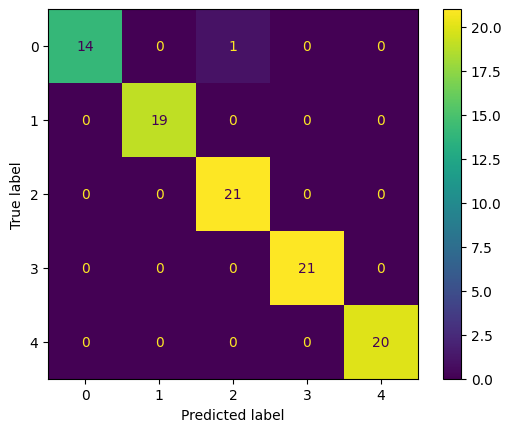

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
ConfusionMatrixDisplay(cm).plot()


In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes))


              precision    recall  f1-score   support

           0       1.00      0.73      0.85        15
           1       1.00      1.00      1.00        19
           2       0.84      1.00      0.91        21
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        20

    accuracy                           0.96        96
   macro avg       0.97      0.95      0.95        96
weighted avg       0.96      0.96      0.96        96



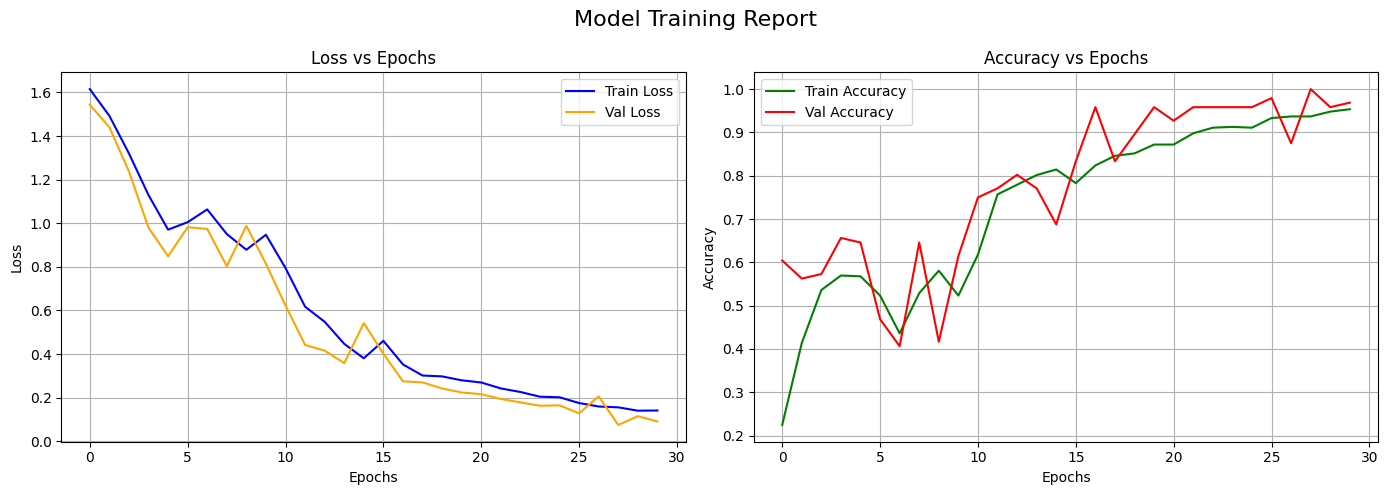

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax[0].plot(history.history['loss'], label='Train Loss', color='blue')
ax[0].plot(history.history['val_loss'], label='Val Loss', color='orange')
ax[0].set_title('Loss vs Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

# Accuracy plot
ax[1].plot(history.history['accuracy'], label='Train Accuracy', color='green')
ax[1].plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
ax[1].set_title('Accuracy vs Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(True)

plt.suptitle("Model Training Report", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
model.save("sign_model_dynamic_mark1.h5") # saving model to use in real time prediction 

In [ ]:
import joblib
joblib.dump(le, "label_encoder_dynamic.pkl") # saving encoder use in real time model with pkl 